### lecture 3: Bellman Optimality Equation

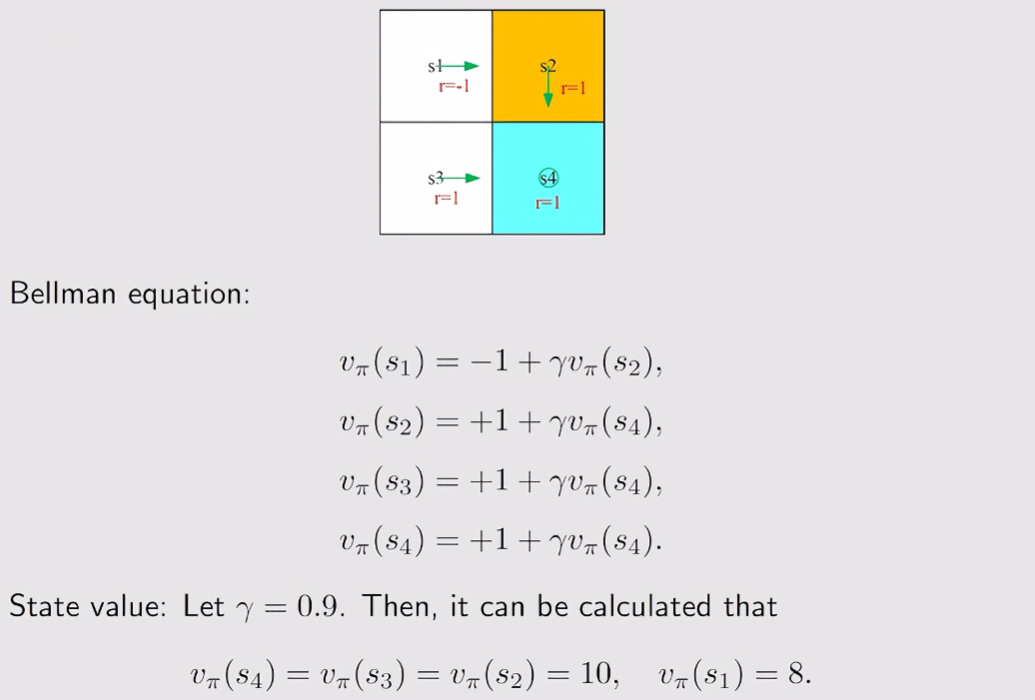

In [3]:
from bellman_equation import *